In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import finesse
from scipy.optimize import minimize
from finesse.gaussian import BeamParam
import matplotlib.colors as colors
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate

finesse.configure(plotting=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import seaborn as sns
# sns.set_theme()
# sns.set_context("paper")

### aLIGO design

The RoCs at SR3.p2, SR3.p1, SR2.p2, SR2.p1, SRM.p2 and SRM.p1 are:
18.217, -1411.315, 20.745, 2.774, 5.715, 5.724 

The mirror RoC of SR3, SR2 and SRM are:
35.973, -6.406 and -5.694

The beam size on the SRM is 0.002 m.


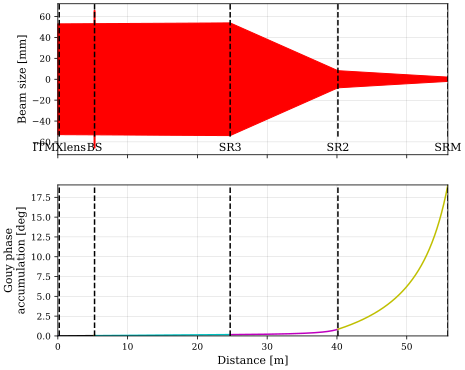

In [5]:
aLIGO = finesse.Model()
aLIGO.parse_file("aLIGO.kat")
aLIGO.remove(aLIGO.cavXARM)
# aLIGO.remove(aLIGO.cavYARM)
aLIGO.remove(aLIGO.cavOMC)
aLIGO.remove(aLIGO.IMC) # gauss command

# aLIGO.ITMXlens.f = 50e3
trace = aLIGO.beam_trace()

ITMX_TO_SRM = aLIGO.path(aLIGO.ITMX.p1, aLIGO.SRM.p1)
pb_LIGO = aLIGO.propagate_beam(path=ITMX_TO_SRM)

print("The RoCs at SR3.p2, SR3.p1, SR2.p2, SR2.p1, SRM.p2 and SRM.p1 are:")
print(f"{trace[aLIGO.SR3.p2.i].qx.Rc:.3f}, {trace[aLIGO.SR3.p1.o].qx.Rc:.3f}, {trace[aLIGO.SR2.p2.i].qx.Rc:.3f}, \
{trace[aLIGO.SR2.p1.o].qx.Rc:.3f}, {trace[aLIGO.SRM.p2.i].qx.Rc:.3f}, {trace[aLIGO.SRM.p1.o].qx.Rc:.3f} \
")

print()
print("The mirror RoC of SR3, SR2 and SRM are:")
print(f"{aLIGO.SR3.Rcx.value:.3f}, {aLIGO.SR2.Rcx.value:.3f} and {aLIGO.SRM.Rcx.value:.3f}")
print()

print(f"The beam size on the SRM is {trace[aLIGO.SRM.p2.i].qx.w:.3f} m.")

fig, axes = pb_LIGO.plot();

fig.savefig('aLIGO_bp.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [4]:
aLIGO_ARM = finesse.Model()
aLIGO_ARM.parse("""
variable nsilica 1.45
variable Mloss 30u

laser L0 P=1
s l1 L0.p1 ITMlens.p1
lens ITMlens f=34500
s l2 ITMlens.p2 ITM.p1
m ITM T=0.014 L=Mloss R=1-ITM.L-ITM.T Rc=-1934
s L ITM.p2 ETM.p1 L=3994
m ETM T=5u L=Mloss R=1-ETM.L-ETM.T Rc=2245
cav cavARM ITM.p2.o

""")
aLIGO_ARM.cavARM.info_parameter_table()

trace = aLIGO.beam_trace()
w_ETM = trace[aLIGO.ETMX.p1.i].qx.w
print(f"The beam size on the ETM (aLIGO) is {w_ETM:.5f} m, assuming mirror radius of 0.17 m:")
print(f"The ratio of the beam size to the mirror size is {w_ETM/0.17:.5f}")

The beam size on the ETM (aLIGO) is 0.06196 m, assuming mirror radius of 0.17 m:
The ratio of the beam size to the mirror size is 0.36448


### Reverse aLIGO (beam-expanding telescopes in the interferometer arms).
#### Focusing on the mode matching between the X arm and SEC:
<div style="text-align:center">
<img src="./Assets/designs.png" alt="CE drawing" width="1000"/>
</div>

### Given mirror size (R=34 cm twice as large as aLIGO), and ARM length $\mathrm{L_{cav}}=40$ km: 
#### Find cavity waist size $w_{0}$, beam size $w$ and test mass RoC $R_{c}$, assuming 1 ppm clipping loss, and symmetric arms.

$$
\begin{align}
z_{R} &= \frac{\pi w_{0}^{2}}{\lambda} \\
q &= \frac{L}{2} + 1j\cdot z_R \\
HG_{0,0}(q) &\overset{\text{clipping loss}}{ \underset{\text{on R=34 cm}}{\Longrightarrow}} w_{0} \overset{}{\Longrightarrow} R_{c} = \frac{L}{2} + z_R^2/\frac{L}{2} \text{, } w = w_{0}\cdot \sqrt{1+(\frac{L}{2z_{R}})^2} 
\end{align}
$$

In [5]:
L = 40e3
lam = 1064e-9

def func(w0, Rm):
    """
    Calculate the test mass RoC and the beam size given the mirror size (radius 34 cm) and cavity length 40 km and 
    1ppm clipping loss requirement
    """
    zR = np.pi*w0**2/lam
    w = w0*np.sqrt(1+(L/2/zR)**2)
    q = L/2 + 1j*zR
    HG00 = finesse.gaussian.HGMode(q, n=0, m=0)
    x = y = np.linspace(-Rm, Rm, 1000)
    xv, yv = np.meshgrid(x, y)
    step = x[1] - x[0]
    HG00data = HG00.unm(x, y) # outputs the first three lines
    circularMask = np.ones_like(HG00data)
    circularMask[(xv**2+yv**2)>=Rm**2] = 0
    HG00data = HG00data*circularMask
    # plt.imshow(abs(HG00data))
    # plt.colorbar()
    print()
    print(f"The beam size on the mirror is {w:.4f} m with a waist of {w0:.3f} m")
    print(f"The beam size to mirror radius ratio is {w/Rm:.2f}")
    
    clipping = 1-np.sum(np.abs(HG00data**2*step**2))
    print(f"The clipping on a radius-{Rm*100:.1f} cm mirror is {clipping*1e6:.4f} ppm")

    zR = np.pi*w0**2/lam
    Rc = L/2 + zR**2/(L/2)
    print()
    print(f"Test mass RoC {Rc/1e3:.4f} km")
    print(f"aLIGO test mass RoCs are (1.934, 2.245) km")

func(w0=0.0587837, Rm=0.34) #0.11523
# waist size of 10cm gives 1ppm clipping loss on a raidus-34cm mirror 

(2.117896767114238+1.2971347547137413j)
1.0
(0.0005603807370818812-0.0008275462465762317j)

The beam size on the mirror is 0.1294 m with a waist of 0.059 m
The beam size to mirror radius ratio is 0.38
The clipping on a radius-34.0 cm mirror is 1.0000 ppm

Test mass RoC 25.2049 km
aLIGO test mass RoCs are (1.934, 2.245) km


### Beam-expanding telescopes **INSIDE** CE arms:

In [6]:
variables = """
# ------------------------------------------------------------------------------
# variables
# ------------------------------------------------------------------------------
variable nsilica 1.44963098985906
variable Mloss 30u

variable L_ARM 40k
variable TM_Rc 25.2049k

variable PRMRc 50
variable SEMRc -50
variable l_PRM_BS 50
variable l_BS_SEM 50

variable l_BS_XM2 50
variable XM2Rc -50
variable l_XM2_XM3 50
variable XM3Rc 50

variable l_XM3_ITMXlens 50

variable ITMX_lensf 10k
"""

In [7]:
base = finesse.Model()
base.parse(variables)
base.parse("""
l l1 P=165
s ll1_PRM l1.p1 PRMAR.p1

# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRMAR R=0 T=0.99996 # compound mirrors PRM, ITMX, and SEM
s sPRMsub PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM R=0.9699915 T=0.03 Rc=PRMRc
s lPRM_BS PRM.p2 BS.p1 L=l_PRM_BS

bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lBS_XM2 BS.p3 XM2.p1 L=l_BS_XM2
bs XM2 T=250u L=37.5u alpha=-1 Rc=XM2Rc
s lXM2_XM3 XM2.p2 XM3.p1 L=l_XM2_XM3
bs XM3 T=0 L=37.5u alpha=1 Rc=XM3Rc
s lXM3_ITMXlens XM3.p2 ITMX_lens.p1 L=l_XM3_ITMXlens

lens ITMX_lens ITMX_lensf

s lITMX ITMX_lens.p2 ITMXAR.p1

m ITMXAR T=0.99998 L=20u
s sITMXsub1 ITMXAR.p2 ITMX.p1 L=0.4 nr=nsilica
m ITMX T=0.014 L=Mloss phi=0 Rc=-TM_Rc

s LY ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=Mloss phi=0 Rc=TM_Rc

cav cavXARM source=ITMX.p2.o via=ETMX.p1.i priority=2
#cav cavPRX PRM.p2.o via=ITMX.p1.i priority=1
# ------------------------------------------------------------------------------
# Sginal recycling cavity
# ------------------------------------------------------------------------------
s lBS_SEM BS.p4 SEM.p1 L=l_BS_SEM
m SEM R=0.7999913 T=0.2 L=8.7u Rc=SEMRc
s SEMsub SEM.p2 SEMAR.p1 L=0.0749 nr=nsilica
m SEMAR R=0 T=0.99999995 L=50n
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Power detectors
# ------------------------------------------------------------------------------
"""
)

In [9]:
trace = base.beam_trace()
trace[base.ETMX.p1.i].qx.w

0.12935784394627095

## Mode Matching between ARM and SEC
<div style="text-align:center">
<img src="./Assets/reverse aLIGO.png" alt="CE drawing" width="500"/>
</div>

$$R_{c} = z + \frac{z_R^2}{z} $$

1. Find an aLIGO-like mode matching solution from the ARM to the SEC, 5 degrees of freedom.
2. Identify the two most sensitive dofs around the solution, and explore the infinite continuous perfectly mode matched solution (landscape) around that solution,
3. At the same time, consider other figures of merits, such at the accumulated Gouy phase for SEC, beam sizes etc,
3. Explore beyond the two dimensional landscape by including the third most sensitive dof.

The SEM RoC is -79.5919


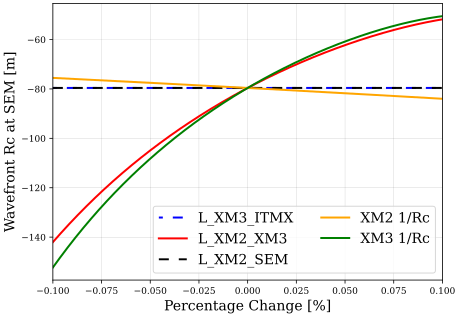

In [112]:
kat = base.deepcopy()

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30

XM2Rc = -9.6
XM3Rc = 100
ITMX_lensf = np.inf

SEMRc = -79.59188
PRMRc = 50
l_PRM_BS = 50

kat.PRMRc.value = PRMRc
kat.SEMRc.value = SEMRc
kat.l_PRM_BS.value = l_PRM_BS
kat.l_BS_SEM.value = l_BS_SEM
kat.l_BS_XM2.value = l_BS_XM2
kat.XM2Rc.value = XM2Rc
kat.l_XM2_XM3.value = l_XM2_XM3
kat.XM3Rc.value = XM3Rc
kat.l_XM3_ITMXlens.value = l_XM3_ITMXlens
kat.ITMX_lensf.value = ITMX_lensf

katt = kat.deepcopy()

ITMX_TO_SEM = katt.path(katt.ITMX.p1, katt.SEM.p1)
SEC_ps_sym = katt.propagate_beam(path=ITMX_TO_SEM, symbolic=True)
Rc_SEM_1_sym = SEC_ps_sym.q(katt.SEM.p1.i).Rc
print(f"The SEM RoC is {Rc_SEM_1_sym.eval():.4f}")
xrange = np.linspace(-0.01, 0.01, 500)/10
xrange_xaxis = xrange*100

# K = 1/ITMX_lensf
# Krange = K*(1 - xrange)
# ITMXlensf_range = 1/Krange
# Rc_SEM_1_val = Rc_SEM_1_sym.eval(subs={'ITMX_lens.f': ITMXlensf_range}) 

XM3_ITMXlensl_range = l_XM3_ITMXlens*(1 + xrange)
Rc_SEM_2_val = Rc_SEM_1_sym.eval(subs={'lXM3_ITMXlens.L': XM3_ITMXlensl_range}) 

XM2XM3l_range = l_XM2_XM3*(1 + xrange)
Rc_SEM_3_val = Rc_SEM_1_sym.eval(subs={'lXM2_XM3.L': XM2XM3l_range}) 

BS_SEMl_range = l_BS_SEM*(1 + xrange)
Rc_SEM_4_val = Rc_SEM_1_sym.eval(subs={'lBS_SEM.L': BS_SEMl_range}) 

XM2S_range = (1/XM2Rc)*(1 + xrange)
XM2Rc_range = 1/XM2S_range
Rc_SEM_5_val = Rc_SEM_1_sym.eval(subs={'XM2.Rcx': XM2Rc_range}) 

XM3S_range = (1/XM3Rc)*(1 + xrange)
XM3Rc_range = 1/XM3S_range
Rc_SEM_6_val = Rc_SEM_1_sym.eval(subs={'XM3.Rcx': XM3Rc_range}) 

fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(xrange_xaxis, Rc_SEM_1_val, lw=2, label="ITMX_lens 1/f", ls=(5, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_2_val, lw=2, label="L_XM3_ITMX", ls=(3, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_3_val, lw=2, label="L_XM2_XM3")
ax.plot(xrange_xaxis, Rc_SEM_4_val, lw=2, label="L_XM2_SEM", ls=(0, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_5_val, lw=2, label="XM2 1/Rc")
ax.plot(xrange_xaxis, Rc_SEM_6_val, lw=2, label="XM3 1/Rc")

ax.set_xlabel("Percentage Change [%]", fontsize=14)
ax.set_ylabel("Wavefront Rc at SEM [m]", fontsize=14)

ax.legend(loc="best", ncol=2, fontsize=14);

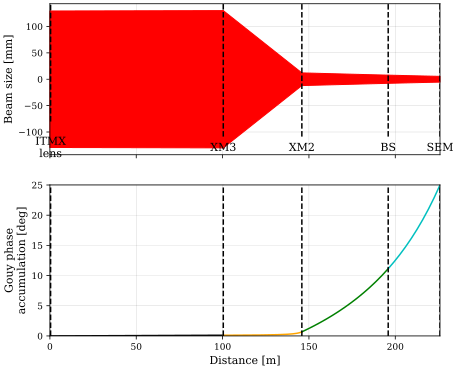

SEC RoC is -79.59188167303567


In [13]:
pb_SEC = katt.propagate_beam(path=ITMX_TO_SEM)
pb_SEC.plot(figsize=(7, 3));
SEM_Rc_fixed = pb_SEC.q(katt.SEM.p1.i).Rc
print(f"SEC RoC is {SEM_Rc_fixed}")

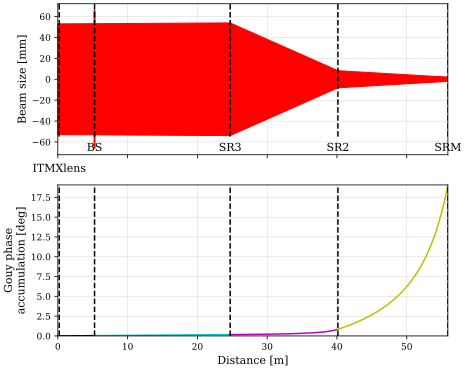

In [14]:
ITMX_TO_SRM = aLIGO.path(aLIGO.ITMX.p1, aLIGO.SRM.p1)
pb_LIGO = aLIGO.propagate_beam(path=ITMX_TO_SRM)
pb_LIGO.plot(name_yoffsets={"ITMXlens":-20}, figsize=(7, 3));

In [15]:
def func_XM3R_lXM2_XM3(XM3_Rc, args):
    lXM2_XM3,  = args

    kat1 = kat.deepcopy()
    kat1.lXM2_XM3.L = lXM2_XM3
    # print(args)
    kat1.XM3.Rc = XM3_Rc

    trace1 = kat1.beam_trace()
    SEMRC = trace1[kat1.SEM.p1.i].qx.Rc
    # print(abs(SEMRC-SEM_Rc_fixed))

    return abs(SEMRC-SEM_Rc_fixed)

In [16]:
res = minimize(func_XM3R_lXM2_XM3, x0=100+0.2, args=[45.5+0.1], method='Nelder-Mead', tol=1e-5)
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3437834780916091e-05
             x: [ 1.002e+02]
           nit: 27
          nfev: 55
 final_simplex: (array([[ 1.002e+02],
                       [ 1.002e+02]]), array([ 1.344e-05,  2.104e-05]))

In [17]:
res.x

array([100.19841172])

In [18]:
# lXM2_XM3_range = np.linspace(43.551, 43.552, 5)
lXM2_XM3_range = np.linspace(41, 48, 50)
XM3Rc_range = []
Gouy_SECs = []
w_SEMs = []
w_BSs = []

for lXM2_XM3 in lXM2_XM3_range:
    res = minimize(func_XM3R_lXM2_XM3, x0=100+(lXM2_XM3-45.5)*2, args=[lXM2_XM3], method='Nelder-Mead', tol=1e-7)
    # initial guess for SEMRC increases by 2 (100) if the lXM2_XM3 change by 1 (45)
    if res.success and res.fun<1e-3:
        XM3Rc_range.append(res.x)
            
        kat2 = kat.deepcopy()
        kat2.lXM2_XM3.L = lXM2_XM3
        kat2.XM3.Rc = res.x
        
        # kat2.propagate_beam(kat2.XM2.p2.i, kat2.SEM.p1).plot("beamsize", figsize=(7, 3))

        ITMX_TO_SEM = kat2.path(kat2.ITMX.p1, kat2.SEM.p1)
        pb_SEC = kat2.propagate_beam(path=ITMX_TO_SEM)
        
        Gouy_SEC = pb_SEC.acc_gouy("lXM3_ITMXlens", "lXM2_XM3", "lBS_XM2", "lBS_SEM")
        Gouy_SECs.append(Gouy_SEC)

        w_SEMs.append(pb_SEC.q(kat2.SEM.p1.i).w)
        w_BSs.append(pb_SEC.q(kat2.BS.p3.i).w)
    else:
        print(f"Can't find a optimization solution when lXM2_XM3={lXM2_XM3:.2f}")

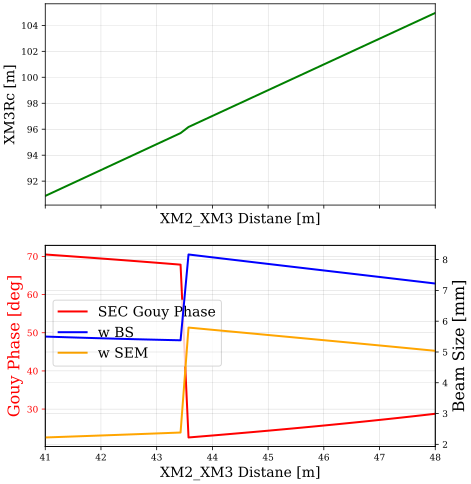

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

lns1, = ax1.plot(lXM2_XM3_range, XM3Rc_range, color="green", lw=2, label="Perfect MM at SEM")

lns2, = ax2.plot(lXM2_XM3_range, Gouy_SECs, color="red", ls="-", lw=2, label="SEC Gouy Phase")
ax3 = ax2.twinx()
lns3, = ax3.plot(lXM2_XM3_range, np.array(w_BSs)*1e3, color="blue", ls="-", lw=2, label="w BS")
lns4, = ax3.plot(lXM2_XM3_range, np.array(w_SEMs)*1e3, color="orange", ls="-", lw=2, label="w SEM")

ax2.set_xlabel("XM2_XM3 Distane [m]", fontsize=14)
ax1.set_xlabel("XM2_XM3 Distane [m]", fontsize=14)
ax1.set_ylabel("XM3Rc [m]", fontsize=14);
ax2.set_ylabel("Gouy Phase [deg]", fontsize=16, color="red")
ax3.set_ylabel("Beam Size [mm]", fontsize=16)
ax2.tick_params(axis='y', labelcolor="red", color="red")
lns = [lns2, lns3, lns4]
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=(0.02, 0.4), fontsize=14);

In [67]:
# lXM2_XM3_range = np.linspace(43.5512, 43.5515, 4)

# for lXM2_XM3 in lXM2_XM3_range:
#     res = minimize(func_XM3R_lXM2_XM3, x0=100+(lXM2_XM3-45.5)*2, args=[lXM2_XM3], method='Nelder-Mead', tol=1e-7)
#     if res.success and res.fun<1:            
#         kat2 = kat.deepcopy()
#         kat2.lXM2_XM3.L = lXM2_XM3
#         kat2.XM3.Rc = res.x

#         print(f"lXM2_XM3 = {lXM2_XM3:.4f}: ")
#         kat2.propagate_beam(kat2.XM3.p2.i, kat2.SEM.p1).plot("beamsize", figsize=(7, 3))

In [21]:
lXM2_XM3_range = np.linspace(41, 48, 20)
def ParaSpaceSearch(delta_XM2Rc):
    res = minimize(func_deltaL_deltaXM2Rc, x0=delta_XM2Rc/2, args=[delta_XM2Rc], method='Nelder-Mead', tol=1e-6)
    if res.fun < 1e-3:
        delta_l_XM2_XM3 = res.x
        print(f"The delta_l_XM2_XM3 when delta_XM2Rc={delta_XM2Rc} is {delta_l_XM2_XM3[0]}", end="\n")
    else:
        print(f"Cannot find delta_l_XM2_XM3 when delta_XM2Rc={delta_XM2Rc}")

    XM3Rc_range = []
    Gouy_SECs = []
    w_SEMs = []
    w_BSs = []
    for lXM2_XM3 in lXM2_XM3_range:
        res = minimize(func_XM3R_lXM2_XM3_deltaXM2Rc, x0=100+(lXM2_XM3-(45.5+delta_l_XM2_XM3))*2, args=[lXM2_XM3, delta_XM2Rc], 
                       method='Nelder-Mead', tol=1e-7)
        # search for combination of lXM2_XM3 and XM3_Rc, while XM2Rc is changed by delta_XM2Rc, to keep SEM Rc fixed
        if res.success and res.fun<1:
            XM3Rc_range.append(res.x)

            kat2 = kat.deepcopy()
            kat2.lXM2_XM3.L = lXM2_XM3
            kat2.XM2.Rc = -9.6 + delta_XM2Rc # added this
            kat2.XM3.Rc = res.x

            ITMX_TO_SEM = kat2.path(kat2.ITMX.p1, kat2.SEM.p1)
            pb_SEC = kat2.propagate_beam(path=ITMX_TO_SEM)
            Gouy_SEC = pb_SEC.acc_gouy("lXM3_ITMXlens", "lXM2_XM3", "lBS_XM2", "lBS_SEM")
            Gouy_SECs.append(Gouy_SEC)

            w_SEMs.append(pb_SEC.q(kat2.SEM.p1.i).w)
            w_BSs.append(pb_SEC.q(kat2.BS.p3.i).w)
        else:
            print(f"Can't find a optimization solution when lXM2_XM3={lXM2_XM3:.2f}")

    return XM3Rc_range, Gouy_SECs, w_SEMs, w_BSs

In [22]:
def func_deltaL_deltaXM2Rc(delta_l_XM2_XM3, args): # find the correct XM2_XM3 distance while changing the XM2 Rc
    delta_XM2Rc,  = args

    kat1 = kat.deepcopy()
    kat1.XM2.Rc = -9.6 + delta_XM2Rc

    kat1.lXM2_XM3.L = 45.5 + delta_l_XM2_XM3

    trace1 = kat1.beam_trace()
    SEMRC = trace1[kat1.SEM.p1.i].qx.Rc
    # print(abs(SEMRC-SEM_Rc_fixed))

    return abs(SEMRC-SEM_Rc_fixed)

def func_XM3R_lXM2_XM3_deltaXM2Rc(XM3_Rc, args): # 
    lXM2_XM3, delta_XM2Rc = args

    kat1 = kat.deepcopy()
    kat1.lXM2_XM3.L = lXM2_XM3
    kat1.XM2.Rc = -9.6 + delta_XM2Rc
    kat1.XM3.Rc = XM3_Rc

    trace1 = kat1.beam_trace()
    SEMRC = trace1[kat1.SEM.p1.i].qx.Rc
    # print(abs(SEMRC-SEM_Rc_fixed))

    return abs(SEMRC-SEM_Rc_fixed)

In [23]:
res = minimize(func_deltaL_deltaXM2Rc, x0=0.6, args=[1.2], bounds=((-45, None),), method='Nelder-Mead', tol=1e-6) 
# when XM2Rc change by 1, change lXM2_XM3 by 0.5 
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.0727349888384197e-06
             x: [ 5.872e-01]
           nit: 23
          nfev: 47
 final_simplex: (array([[ 5.872e-01],
                       [ 5.872e-01]]), array([ 1.073e-06,  1.805e-06]))

In [24]:
XM3Rc_range_deltas, Gouy_SECs_deltas, w_SEMs_deltas, w_BSs_deltas = [], [], [], []
delta_XM2Rcs = np.linspace(0.8, -0.8, 3)
for delta_XM2Rc in delta_XM2Rcs:
    XM3Rc_range_delta, Gouy_SECs_delta, w_SEMs_delta, w_BSs_delta = ParaSpaceSearch(delta_XM2Rc=delta_XM2Rc)
    XM3Rc_range_deltas.append(XM3Rc_range_delta)
    Gouy_SECs_deltas.append(Gouy_SECs_delta)
    w_SEMs_deltas.append(w_SEMs_delta)
    w_BSs_deltas.append(w_BSs_delta)

The delta_l_XM2_XM3 when delta_XM2Rc=0.8 is 0.3862800312042236
The delta_l_XM2_XM3 when delta_XM2Rc=0.0 is 0.0
The delta_l_XM2_XM3 when delta_XM2Rc=-0.8 is -0.38059309959411625


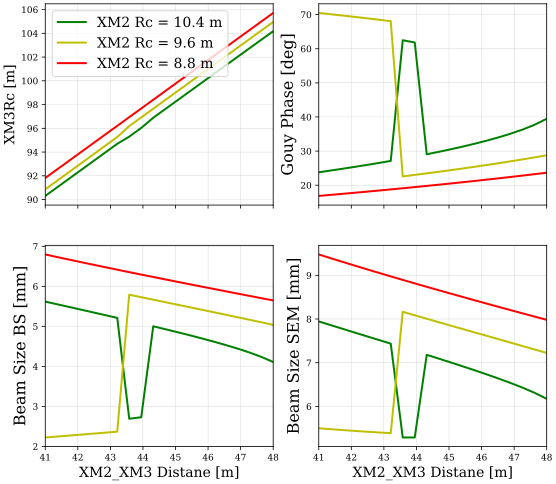

In [25]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(9, 8))

colors = ["g", "y", "r"]
for idx, delta_XM2Rc in enumerate(delta_XM2Rcs):
    ax1.plot(lXM2_XM3_range, XM3Rc_range_deltas[idx], color=colors[idx], lw=2, label=f"XM2 Rc = {9.6+delta_XM2Rc:.1f} m")
    ax2.plot(lXM2_XM3_range, Gouy_SECs_deltas[idx], color=colors[idx], lw=2)
    ax3.plot(lXM2_XM3_range, np.array(w_SEMs_deltas[idx])*1e3, color=colors[idx], lw=2)
    ax4.plot(lXM2_XM3_range, np.array(w_BSs_deltas[idx])*1e3, color=colors[idx], lw=2)

ax3.set_xlabel("XM2_XM3 Distane [m]", fontsize=14)
ax4.set_xlabel("XM2_XM3 Distane [m]", fontsize=14)

ax1.set_ylabel("XM3Rc [m]", fontsize=14);
ax2.set_ylabel("Gouy Phase [deg]", fontsize=16)
ax3.set_ylabel("Beam Size BS [mm]", fontsize=16)
ax4.set_ylabel("Beam Size SEM [mm]", fontsize=16);

ax1.legend(fontsize=14);